# Why Do We Need Data Augmentation?
For starters, it will help us obtain more data for training. Maybe we have a small training set, or maybe we just want to make our training set larger. We can do that by augmenting our existing data and then adding that data to the training set.

Another reason to use data augmentation is to reduce overfitting.

Performing Data Augmentation In Code
Let's now see how we can perform data augmentation using Keras.

First, we import all the libraries we'll be using.

In [80]:
import random
import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET

from pathlib import Path
import os

from tensorflow.keras.applications import vgg16

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, optimizers
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
%matplotlib inline

Next, we'll use this plotImages() function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.

In [127]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[3],x[2],x[5],x[4]]) #ymin,xmin,ymax,xmax

#Reading an image
def read_image(path):
    return cv2.imread(str(path))

def resize_image(read_path,write_path,bb,sz):
    """Resize an image and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    #im_resized = cv2.resize(im, (224, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path,im_resized)
    return new_path, mask_to_bb(Y_resized)

def visualize_results_bb(history):
    # Plot the accuracy and loss curves
    class_acc = history.history['class_label_accuracy']
    class_val_acc = history.history['val_class_label_accuracy']
    class_loss = history.history['class_label_loss']
    class_val_loss = history.history['val_class_label_loss']
    
    bb_acc = history.history['bounding_box_accuracy']
    bb_val_acc = history.history['val_bounding_box_accuracy']
    bb_loss = history.history['bounding_box_loss']
    bb_val_loss = history.history['val_bounding_box_loss']
 
    epochs = range(len(class_acc))

    figure, axis = plt.subplots(2, 2, figsize=(12,12))
 
    axis[0, 0].plot(epochs, class_acc, 'b', label='Training acc')
    axis[0, 0].plot(epochs, class_val_acc, 'r', label='Validation acc')
    axis[0, 0].set_title('Training and validation class accuracy')
    axis[0, 0].legend()
    
    axis[0, 1].plot(epochs, class_loss, 'b', label='Training loss')
    axis[0, 1].plot(epochs, class_val_loss, 'r', label='Validation loss')
    axis[0, 1].set_title('Training and validation class loss')
    axis[0, 1].legend()
    
    axis[1, 0].plot(epochs, bb_acc, 'b', label='Training acc')
    axis[1, 0].plot(epochs, bb_val_acc, 'r', label='Validation acc')
    axis[1, 0].set_title('Training and validation bb accuracy')
    axis[1, 0].legend()
    
    axis[1, 1].plot(epochs, bb_loss, 'b', label='Training loss')
    axis[1, 1].plot(epochs, bb_val_loss, 'r', label='Validation loss')
    axis[1, 1].set_title('Training and validation bb loss')
    axis[1, 1].legend()
    
    plt.show()
    return

In [82]:
path='Data/Dog'
#chosen_image = random.choice(os.listdir(path))
chosen_image= 'dog 996.jpg'
print(chosen_image)

dog 996.jpg


In [83]:
image_path = path + '/'+chosen_image
print(image_path)

Data/Dog/dog 996.jpg


Note, to follow along, you will need to point to a valid location and image file on your machine.

Next, we'll obtain the image by reading the image from disk by using plt.imread() and passing in the image_path. We also, expand the dimensions so that the image is compatible for how we'll use it later.

In [84]:
plT=plt.imread(image_path)
image = np.expand_dims(plT,0)

Now, we'll plot the image just to see what the original image looks like.



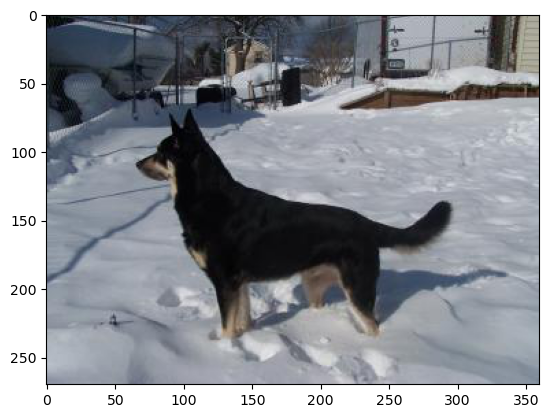

In [85]:
plt.imshow(image[0])

In [86]:
annot = pd.read_csv('annot.csv', index_col = 'id')
annot = annot[['Unnamed: 12','annotator','label','annotation_id','created_at','image']]

In [87]:
annot.head()

,Unnamed: 12,annotator,label,annotation_id,created_at,image
id,,,,,,
1,/data/upload/2/08b7dbca-cat_9999.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 26.857887874837026","""y"": 18.434782608695652","""width"": 47.45762711864407","""height"": 72.69565217391303"
2,/data/upload/2/24e99a91-cat_9998.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 3.65058670143416","""y"": 1.9332161687170506","""width"": 93.87222946544976","""height"": 94.02460456941984"
3,/data/upload/2/2a057339-cat_9997.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 36.329588014981276","""y"": 12.265758091993186","""width"": 52.62172284644193","""height"": 47.18909710391823"
4,/data/upload/2/889afd75-cat_9996.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 16.753246753246753","""y"": 10.721247563352826","""width"": 76.88311688311688","""height"": 72.70955165692008"
5,/data/upload/2/e1f0e217-cat_9995.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 4.968944099378882","""y"": 4.599659284497445","""width"": 94.72049689440993","""height"": 94.54855195911414"


In [88]:
annot.rename(columns={'label':'xmin','annotation_id':'ymin','created_at':'width','image':'height',
                      'annotator':'label','Unnamed: 12':'filepath'}, inplace=True)
annot.head()

,filepath,label,xmin,ymin,width,height
id,,,,,,
1,/data/upload/2/08b7dbca-cat_9999.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 26.857887874837026","""y"": 18.434782608695652","""width"": 47.45762711864407","""height"": 72.69565217391303"
2,/data/upload/2/24e99a91-cat_9998.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 3.65058670143416","""y"": 1.9332161687170506","""width"": 93.87222946544976","""height"": 94.02460456941984"
3,/data/upload/2/2a057339-cat_9997.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 36.329588014981276","""y"": 12.265758091993186","""width"": 52.62172284644193","""height"": 47.18909710391823"
4,/data/upload/2/889afd75-cat_9996.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 16.753246753246753","""y"": 10.721247563352826","""width"": 76.88311688311688","""height"": 72.70955165692008"
5,/data/upload/2/e1f0e217-cat_9995.jpg,"""rectanglelabels"": [""cat""]","[{""x"": 4.968944099378882","""y"": 4.599659284497445","""width"": 94.72049689440993","""height"": 94.54855195911414"


In [89]:
annot.xmin = annot.xmin.map(lambda i: i.lstrip('[{"x: '))
annot.ymin = annot.ymin.map(lambda i: i.lstrip('[{"y: '))
annot.width = annot.width.map(lambda i: i.lstrip('"width: '))
annot.height = annot.height.map(lambda i: i.lstrip('"height: '))
class_dict = {' "rectanglelabels": ["cat"]':'cat',' "rectanglelabels": ["dog"]':'dog'}
annot.label = annot.label.map(lambda i: class_dict[i])
annot.filepath = annot.filepath.map(lambda i: i.replace(i[:24], ''))
annot.filepath = annot.filepath.map(lambda i: i.replace('_', ' '))
annot.filepath = annot.filepath.apply(lambda i: 'Data/Dog/'+i if 'dog' in i else 'Data/Cat/'+i)
annot

,filepath,label,xmin,ymin,width,height
id,,,,,,
1,Data/Cat/cat 9999.jpg,cat,26.857887874837026,18.434782608695652,47.45762711864407,72.69565217391303
2,Data/Cat/cat 9998.jpg,cat,3.65058670143416,1.9332161687170506,93.87222946544976,94.02460456941984
3,Data/Cat/cat 9997.jpg,cat,36.329588014981276,12.265758091993186,52.62172284644193,47.18909710391823
4,Data/Cat/cat 9996.jpg,cat,16.753246753246753,10.721247563352826,76.88311688311688,72.70955165692008
5,Data/Cat/cat 9995.jpg,cat,4.968944099378882,4.599659284497445,94.72049689440993,94.54855195911414
...,...,...,...,...,...,...
963,Data/Dog/dog 9961.jpg,dog,0.25940337224383914,0.8665511265164645,65.23994811932555,99.13344887348353
964,Data/Dog/dog 9960.jpg,dog,39.688715953307394,28.89273356401384,34.50064850843061,63.667820069204154
965,Data/Dog/dog 996.jpg,dog,17.63942931258107,25.77854671280277,64.98054474708171,62.45674740484429


In [90]:
annot.xmin=pd.to_numeric(annot.xmin)
annot.ymin=pd.to_numeric(annot.ymin)
annot.width=pd.to_numeric(annot.width)
annot.height=pd.to_numeric(annot.height)
annot['xmax'] = annot.xmin+annot.width
annot['ymax'] = annot.ymin+annot.height
annot.drop(columns=['height','width'], inplace=True)
annot

,filepath,label,xmin,ymin,xmax,ymax
id,,,,,,
1,Data/Cat/cat 9999.jpg,cat,26.857888,18.434783,74.315515,91.130435
2,Data/Cat/cat 9998.jpg,cat,3.650587,1.933216,97.522816,95.957821
3,Data/Cat/cat 9997.jpg,cat,36.329588,12.265758,88.951311,59.454855
4,Data/Cat/cat 9996.jpg,cat,16.753247,10.721248,93.636364,83.430799
5,Data/Cat/cat 9995.jpg,cat,4.968944,4.599659,99.689441,99.148211
...,...,...,...,...,...,...
963,Data/Dog/dog 9961.jpg,dog,0.259403,0.866551,65.499351,100.000000
964,Data/Dog/dog 9960.jpg,dog,39.688716,28.892734,74.189364,92.560554
965,Data/Dog/dog 996.jpg,dog,17.639429,25.778547,82.619974,88.235294


In [91]:
#os.mkdir(Path('new_path'))
df_train = annot.copy()

In [92]:
#Populating Training DF with new paths
new_paths = []
new_bbs = []
train_path_resized = Path('new_path')
print(type(train_path_resized))
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image(Path(row['filepath']), train_path_resized,create_bb_array(row.values),224)
    new_paths.append(new_path) 
    new_bbs.append(new_bb)
print(type(row['filepath']))
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs
df_train

<class 'pathlib.PosixPath'>
<class 'str'>


,filepath,label,xmin,ymin,xmax,ymax,new_path,new_bb
id,,,,,,,,
1,Data/Cat/cat 9999.jpg,cat,26.857888,18.434783,74.315515,91.130435,new_path/cat 9999.jpg,"[10.0, 11.0, 54.0, 32.0]"
2,Data/Cat/cat 9998.jpg,cat,3.650587,1.933216,97.522816,95.957821,new_path/cat 9998.jpg,"[0.0, 1.0, 57.0, 43.0]"
3,Data/Cat/cat 9997.jpg,cat,36.329588,12.265758,88.951311,59.454855,new_path/cat 9997.jpg,"[7.0, 22.0, 33.0, 55.0]"
4,Data/Cat/cat 9996.jpg,cat,16.753247,10.721248,93.636364,83.430799,new_path/cat 9996.jpg,"[6.0, 7.0, 55.0, 41.0]"
5,Data/Cat/cat 9995.jpg,cat,4.968944,4.599659,99.689441,99.148211,new_path/cat 9995.jpg,"[4.0, 4.0, 118.0, 108.0]"
...,...,...,...,...,...,...,...,...
963,Data/Dog/dog 9961.jpg,dog,0.259403,0.866551,65.499351,100.000000,new_path/dog 9961.jpg,"[0.0, 0.0, 118.0, 58.0]"
964,Data/Dog/dog 9960.jpg,dog,39.688716,28.892734,74.189364,92.560554,new_path/dog 9960.jpg,"[16.0, 17.0, 54.0, 32.0]"
965,Data/Dog/dog 996.jpg,dog,17.639429,25.778547,82.619974,88.235294,new_path/dog 996.jpg,"[20.0, 10.0, 72.0, 50.0]"


In [93]:
df_train1=df_train.drop(columns=['filepath','xmin','ymin','xmax','ymax'])
df_train1

,label,new_path,new_bb
id,,,
1,cat,new_path/cat 9999.jpg,"[10.0, 11.0, 54.0, 32.0]"
2,cat,new_path/cat 9998.jpg,"[0.0, 1.0, 57.0, 43.0]"
3,cat,new_path/cat 9997.jpg,"[7.0, 22.0, 33.0, 55.0]"
4,cat,new_path/cat 9996.jpg,"[6.0, 7.0, 55.0, 41.0]"
5,cat,new_path/cat 9995.jpg,"[4.0, 4.0, 118.0, 108.0]"
...,...,...,...
963,dog,new_path/dog 9961.jpg,"[0.0, 0.0, 118.0, 58.0]"
964,dog,new_path/dog 9960.jpg,"[16.0, 17.0, 54.0, 32.0]"
965,dog,new_path/dog 996.jpg,"[20.0, 10.0, 72.0, 50.0]"


In [94]:
def prepare_image(img):
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    print (img_array_expanded_dims)
    print (img_array_expanded_dims.shape)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [95]:
fname = df_train1[['new_path']]
array_list=[]
for i in range(len(fname)):
    im=cv2.imread(str(fname.values[i][0])) #/255 #normalize
    array_list.append(im)

In [96]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()
 

In [97]:
#label encode target- creating dict data type the keys are the class value and the value are the num encoder 
class_dict = {'cat': 0, 'dog': 1}
# coding the class column with a numerical value 
df_train1['class'] = df_train1['label'].apply(lambda x:  class_dict[x])

In [98]:
"""
      *****  VGG16 MODEL FOR TESTING PREPROCESSED IMAGES  *****
"""

# Normalizing the image arrays
X = np.array(array_list)
# Creating an empty tensor to store image arrays
tensor = np.zeros((X.shape[0],224,224,3))
# Iterating through image arrays to update tensor
for idx, i in enumerate(X):
    tensor[idx] = i
X=tensor
y = np.array(df_train1['class'])
y = tf.keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

(65, 224, 224, 3) (28, 224, 224, 3) (65, 2) (28, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 40407874 (154.14 MB)
Trainable params: 25693186 (98.01 MB)
Non-trainable params: 14714688 (56.13 MB)
___________________

Epoch 1/5


2024-10-22 15:28:54.413033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 20.8482 - acc: 0.6000

2024-10-22 15:28:56.307319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 20.8482 - acc: 0.6000 - val_loss: 56.8609 - val_acc: 0.6429
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 53.9789 - acc: 0.6308 - val_loss: 231.3678 - val_acc: 0.3929
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 124.1429 - acc: 0.4923 - val_loss: 18.6071 - val_acc: 0.8214
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 2.5133 - acc: 0.9692 - val_loss: 13.5349 - val_acc: 0.8571
Epoch 5/5
3/3 [==============================] - 1s 260ms/step - loss: 0.0000e+00 - acc: 1.0000


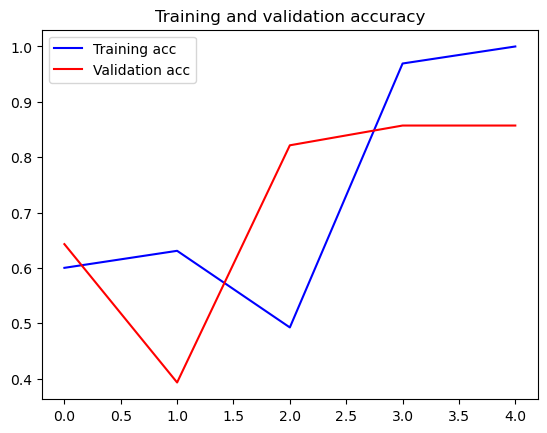

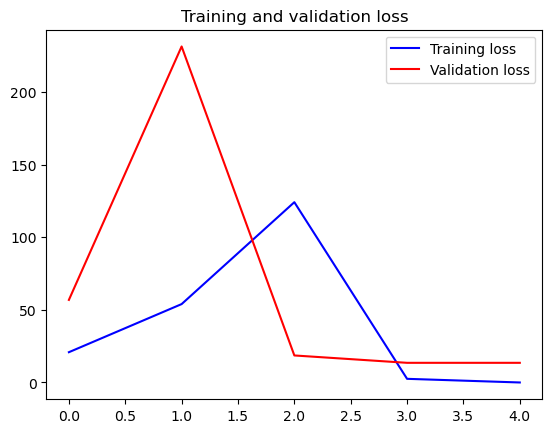

In [99]:
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=5, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

# Bounding box model

following this example: https://pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/

In [100]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

In [117]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(array_list)/ 255.0
# Creating an empty tensor to store image arrays
tensor = np.zeros((data.shape[0],224,224,3))
# Iterating through image arrays to update tensor
for idx, i in enumerate(data):
    tensor[idx] = i
data=tensor

labels = np.array(df_train1['class'])
labels = tf.keras.utils.to_categorical(labels, 2)

bboxes = np.array(df_train.new_bb)/224
tensor = np.zeros((bboxes.shape[0],4))
# Iterating through image arrays to update tensor
for idx, i in enumerate(bboxes):
    tensor[idx] = i
bboxes=tensor

In [118]:
trainImages, testImages,trainLabels, testLabels,trainBBoxes,testBBoxes = train_test_split(data, labels, bboxes,
                                                    test_size=0.20, random_state=42)

In [160]:
"""# load the VGG16 network, ensuring the head FC layers are left off
vgg = vgg16.VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
out = vgg.output
flatten = Flatten()(out)"""

input = Input(shape=(224, 224, 3))
custom_model = Conv2D(64,kernel_size=(3,3), padding='same', activation='relu')(input)
custom_model = Conv2D(64,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(12,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(12,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(256,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(256,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(256,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
split = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(split)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)
                            

# flatten the max-pooling output of VGG
flatten = Flatten()(custom_model)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Conv2D(512, kernel_size=(4,4), activation="relu")(split)
bboxHead = MaxPooling2D(2)(bboxHead)
bboxHead = Flatten()(bboxHead)
bboxHead = Dense(32, activation="sigmoid")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
                    name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(2, activation="softmax",
                    name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=input,outputs=(bboxHead, softmaxHead))
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_91 (Conv2D)          (None, 224, 224, 64)         1792      ['input_43[0][0]']            
                                                                                                  
 conv2d_92 (Conv2D)          (None, 224, 224, 64)         36928     ['conv2d_91[0][0]']           
                                                                                                  
 max_pooling2d_34 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_92[0][0]']           
 ng2D)                                                                                     

In [163]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = vgg16.VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
out = vgg.output
flatten = Flatten()(out)

"""input = Input(shape=(224, 224, 3))
custom_model = Conv2D(64,kernel_size=(3,3), padding='same', activation='relu')(input)
custom_model = Conv2D(64,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(12,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(12,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(256,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(256,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(256,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
split = MaxPooling2D(2)(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(split)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = Conv2D(512,kernel_size=(3,3), padding='same', activation='relu')(custom_model)
custom_model = MaxPooling2D(2)(custom_model)"""
                            

# flatten the max-pooling output of VGG
#flatten = Flatten()(out)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Conv2D(512, kernel_size=(4,4), activation="relu")(out)
bboxHead = MaxPooling2D(2)(bboxHead)
bboxHead = Flatten()(bboxHead)
bboxHead = Dense(32, activation="sigmoid")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
                    name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(2, activation="softmax",
                    name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input,outputs=(bboxHead, softmaxHead))
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_44[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                           

In [164]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [165]:
trainLabels.shape

(74, 2)

In [166]:
print(type(trainImages), type(trainTargets))

<class 'numpy.ndarray'> <class 'dict'>


In [167]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = optimizers.legacy.Adam(learning_rate=5e-5)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

print("[INFO] training model...")
H = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=128,epochs=20,verbose=1)




[INFO] training model...
Epoch 1/20


2024-10-22 16:16:55.360343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 1.6151 - bounding_box_loss: 0.1625 - class_label_loss: 1.4526 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.3784

2024-10-22 16:16:57.053910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 1.6151 - bounding_box_loss: 0.1625 - class_label_loss: 1.4526 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.3784 - val_loss: 1.3837 - val_bounding_box_loss: 0.1325 - val_class_label_loss: 1.2513 - val_bounding_box_accuracy: 0.0000e+00 - val_class_label_accuracy: 0.2632
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 1.1021 - bounding_box_loss: 0.1289 - class_label_loss: 0.9732 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.5000 - val_loss: 0.9564 - val_bounding_box_loss: 0.1053 - val_class_label_loss: 0.8511 - val_bounding_box_accuracy: 0.0000e+00 - val_class_label_accuracy: 0.3684
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 0.9321 - bounding_box_loss: 0.1013 - class_label_loss: 0.8308 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.5946 - val_loss: 0.8774 - val_bounding_box_loss: 0.0846 - val_class_label_loss: 0.7928 - val_bounding_box_ac

Model evaluation: 
3/3 [==============================] - 1s 304ms/step - loss: 0.0739 - bounding_box_loss: 0.0217 - class_label_loss: 0.0521 - bounding_box_accuracy: 0.7432 - class_label_accuracy: 1.0000


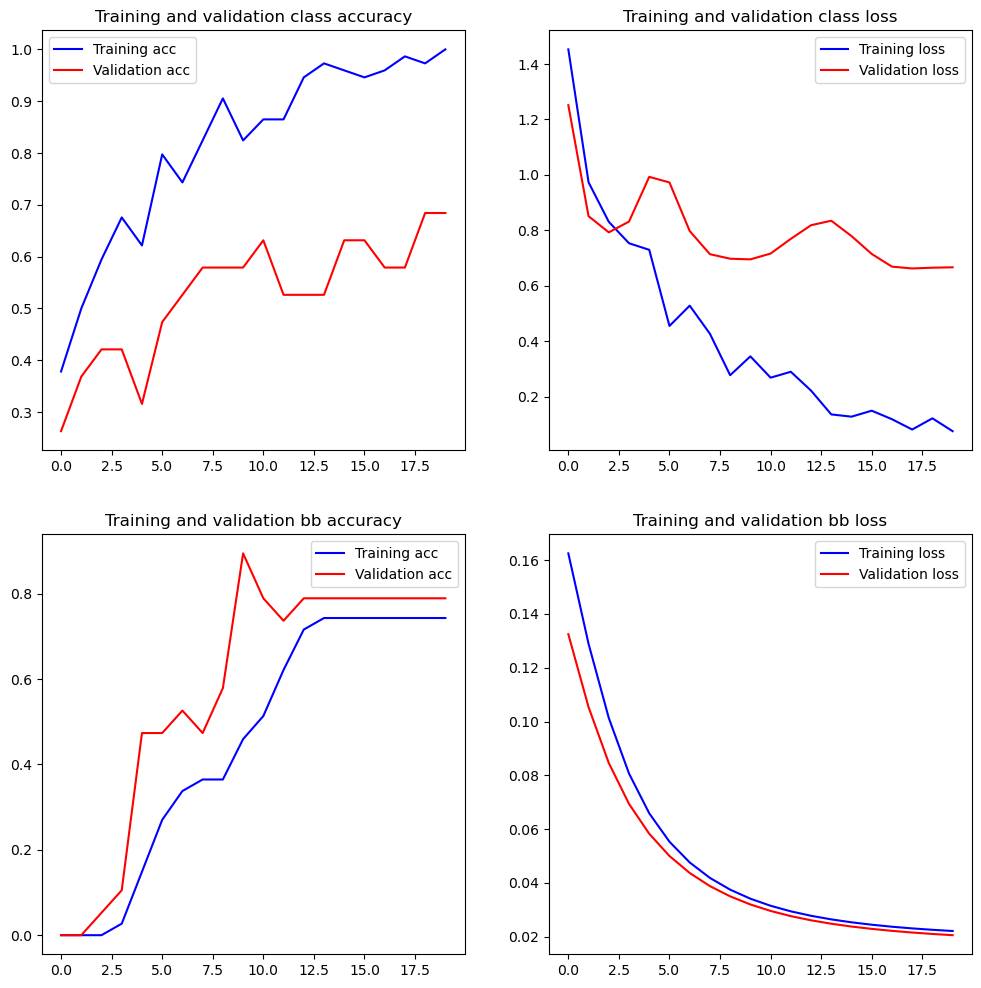

In [168]:
print('Model evaluation: ')
model.evaluate(
    x=trainImages,
    y=trainTargets,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)
visualize_results_bb(H)